# Trabajo Final 

## Diagnóstico Automático de Tuberculosis en Radiografías de Tórax aplicando Machine Learning

La tesis elegida consiste en el análisis, diseño, implementación y prueba de un prototipo que, mediante el CAD (Diagnóstico Asistido por Computadora) y el uso de técnicas de Aprendizaje Automatizado, permita el diagnóstico de la enfermedad tuberculosis pulmonar a partir de imágenes radiográficas de tórax de pacientes de ambos sexos y distintas edades.


Desde el punto de vista de la visión artificial, el diagnóstico asistido por computadoras de tuberculosis se puede dividir en las siguientes cuatro tareas
<img src="https://i.postimg.cc/qv8QmLRY/etapas.png"/>


## Objetivo

Para este trabajo se llegará hasta la segmetación del pulmón de manera automática y aplicando las distintas técnicas de procesamiento de imágenes.
En la tesis se utiliza las mascaras proporcionadas desde el mismo dataset y que se armaron manualmente

## Librerias

In [1]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Instalacion librerias
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import imageio
from skimage.util import random_noise
from PIL import Image, ImageTk
from sklearn.cluster import MeanShift, estimate_bandwidth

In [7]:
import time
import funciones_pdi as nf

In [8]:
def show_image(values, title):
    fig, ax = plt.subplots()
    ax.imshow(values, 'gray')
    ax.set_title(title)
    fig.set_size_inches(18, 10, forward=True)

C:\Users\Fabian\AppData\Local\Temp\ipykernel_10576\3786559129.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('./imagenes/dataset/CHNCXR_0020_0.png')


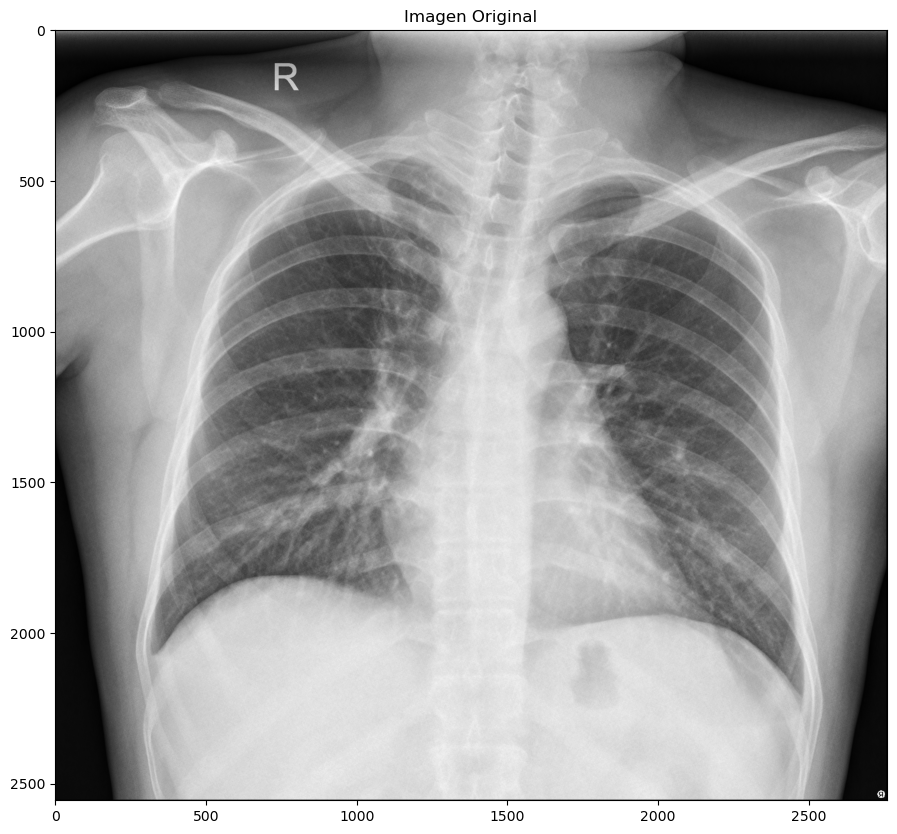

In [61]:
img = imageio.imread('./imagenes/dataset/CHNCXR_0020_0.png')
show_image(img,'Imagen Original')

### Binarización Cuerpo
Primero se busca separar el contorno del cuerpo del paciente con el fin de eliminar datos no relevantes de las esquinas. 

Valor de umbral de Otsu: 139.0


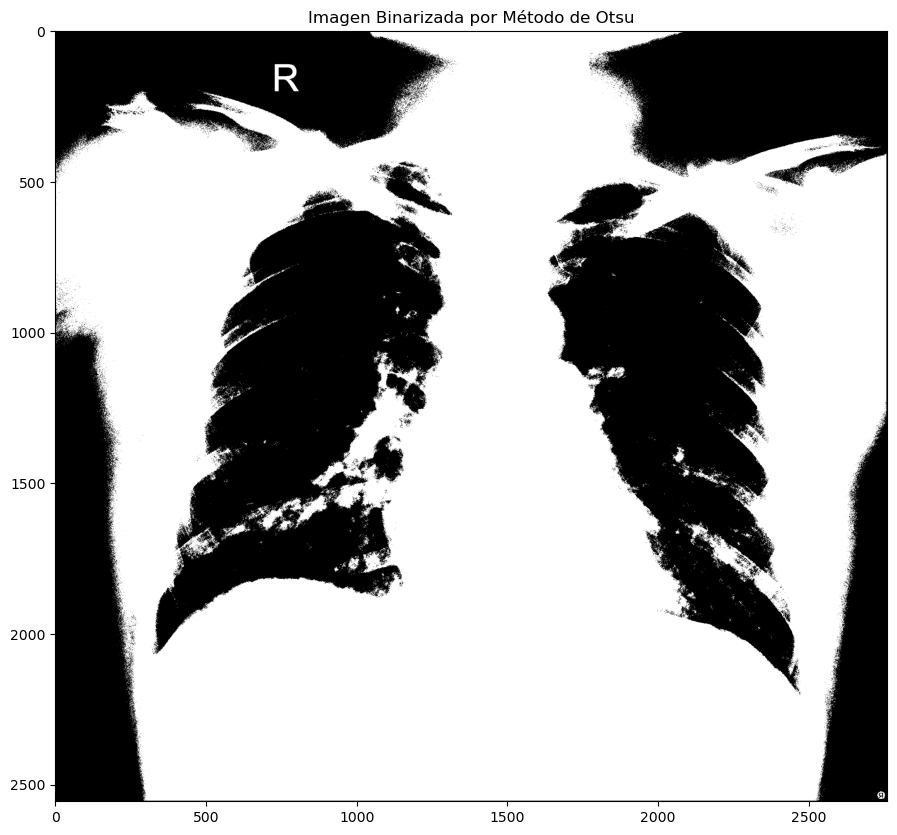

In [62]:
T,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print("Valor de umbral de Otsu: {}".format(T))
show_image(thresh,'Imagen Binarizada por Método de Otsu')

### Operaciones de morfología

In [63]:
kernel = np.ones((9,9),np.uint8)

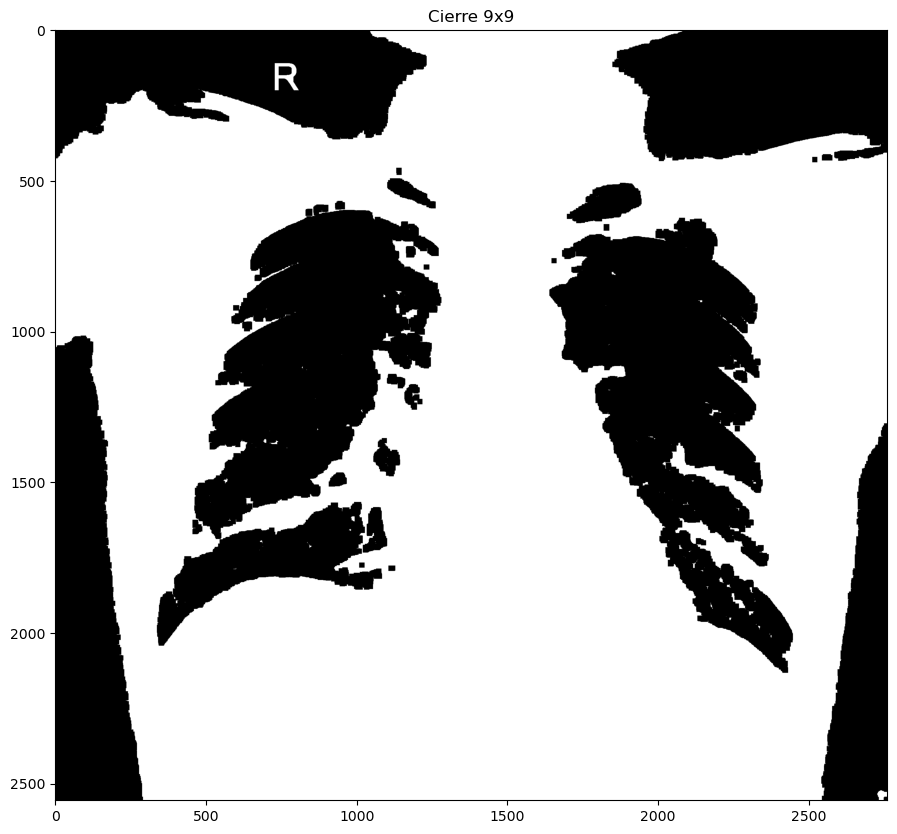

In [64]:
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
show_image(closing,'Cierre 9x9')

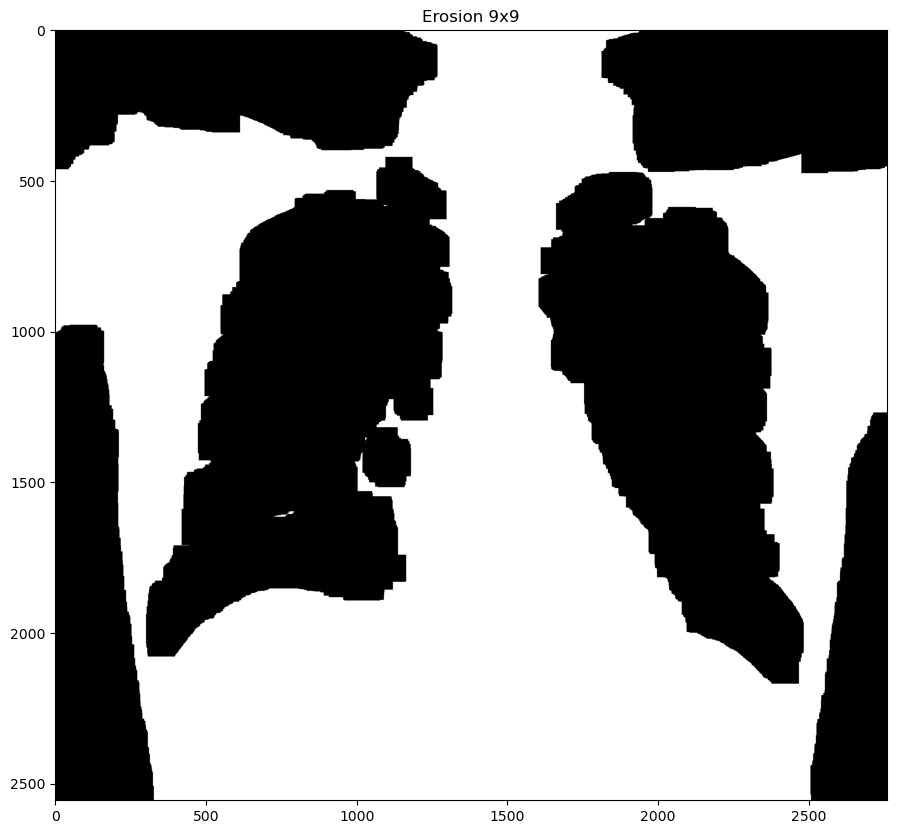

In [65]:
erosion = cv2.erode(closing,kernel,iterations=9)
show_image(erosion,'Erosion 9x9')

### Contorno Externo

In [66]:
contours, _ = cv2.findContours(erosion,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
print("Nºs de contornos:",len(contours))

Nºs de contornos: 1


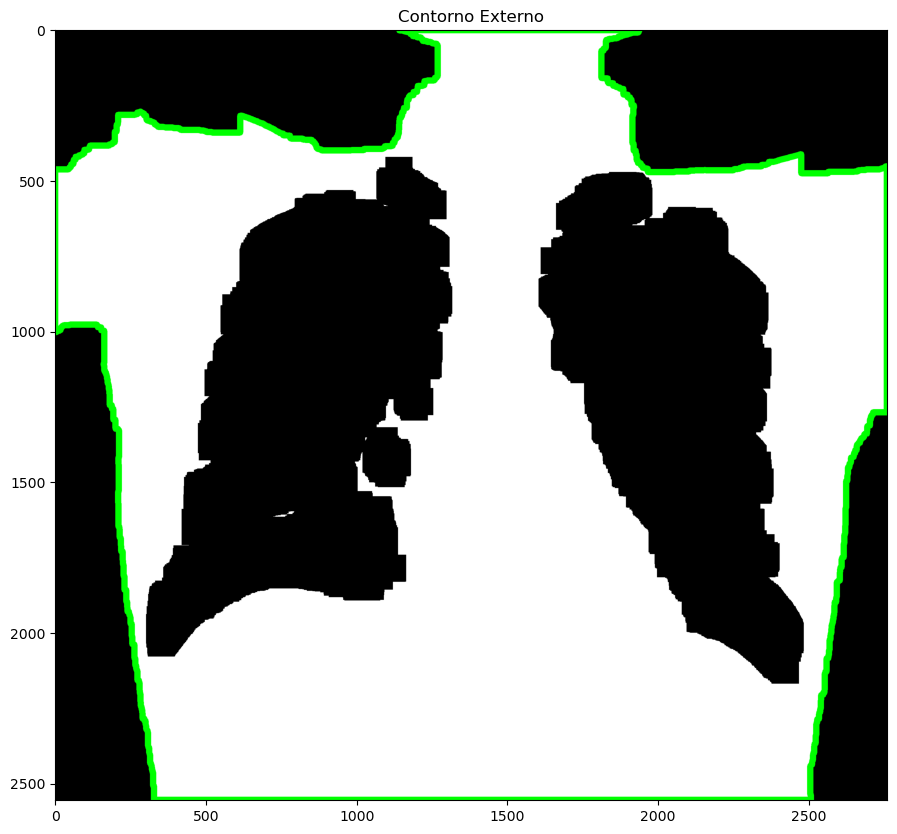

In [67]:
img_RGB = cv2.cvtColor(erosion, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_RGB, contours, -1, (0,255,0), 20)
show_image(img_RGB,'Contorno Externo')

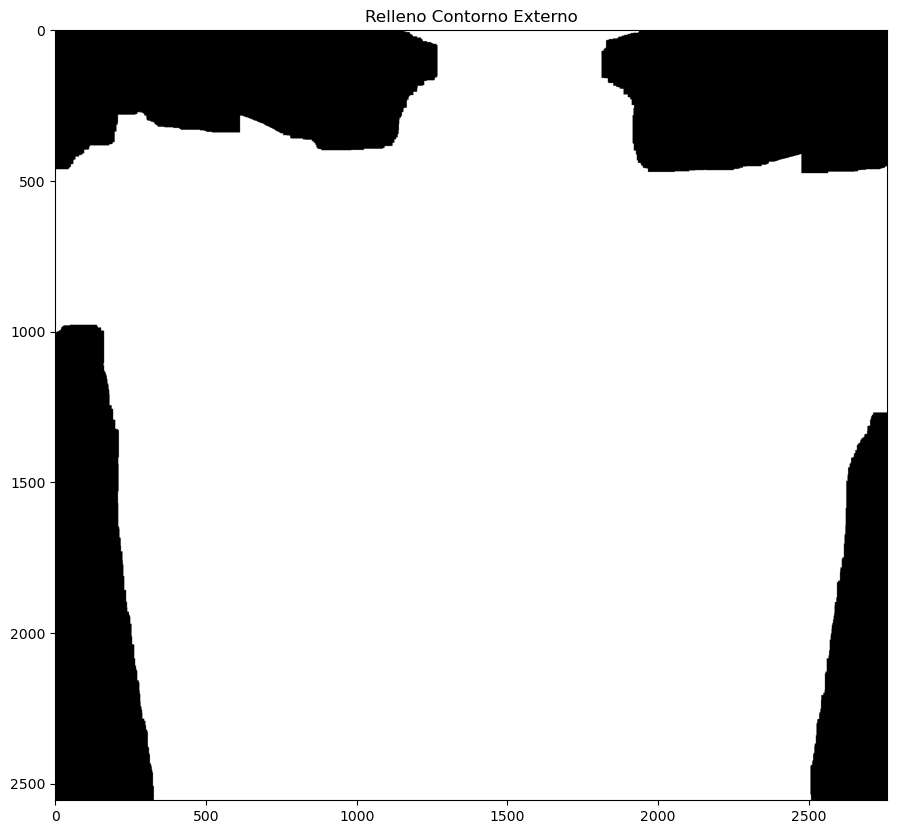

In [68]:
mask = erosion.copy()
cv2.fillPoly(mask, contours, (255,255,255))
show_image(mask,'Relleno Contorno Externo')

### Aplicar Máscara en la imagen

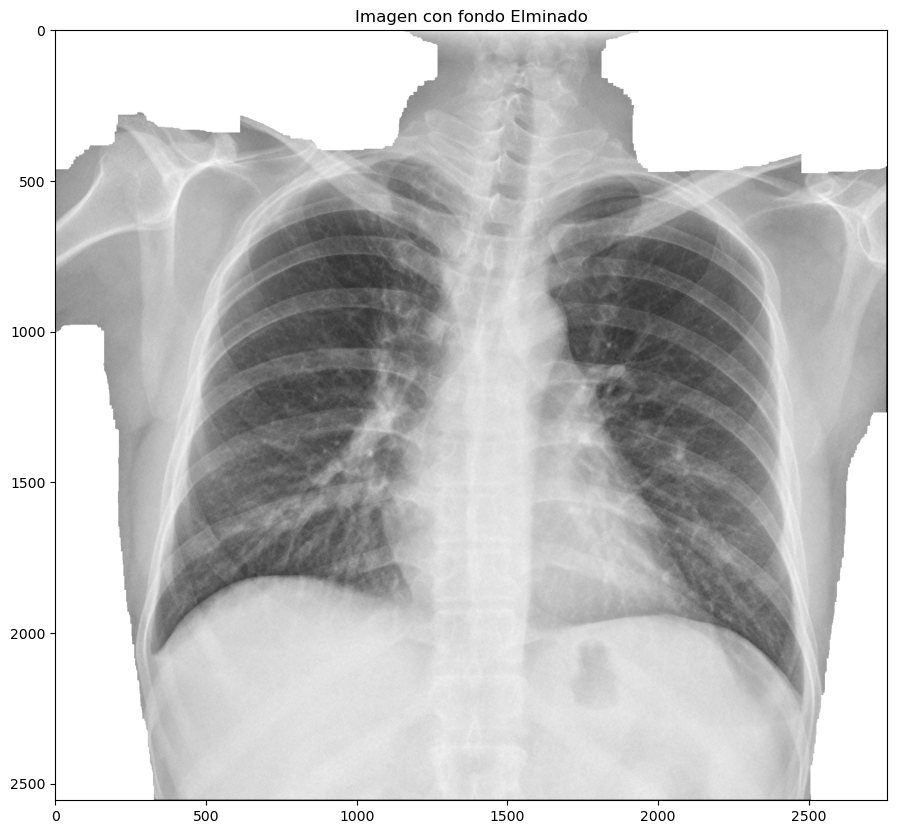

In [69]:
mask_inv = ~mask
final = cv2.bitwise_or(img, mask_inv)
show_image(final,'Imagen con fondo Elminado')

### Binarización Pulmones
Una vez separado el contorno del cuerpo se pasa a la segmentación de los pulmmones

Valor de umbral de Otsu: 171.0


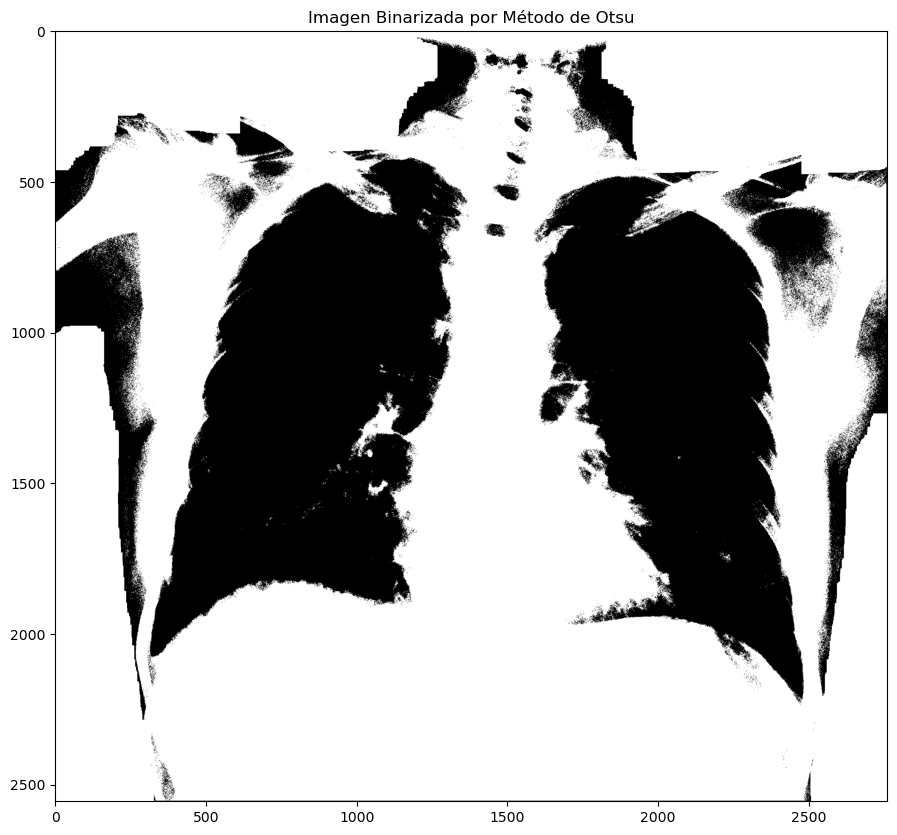

In [70]:
T,thresh_pulmon = cv2.threshold(final,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print("Valor de umbral de Otsu: {}".format(T))
show_image(thresh_pulmon,'Imagen Binarizada por Método de Otsu')

### Operaciones Morfológicas

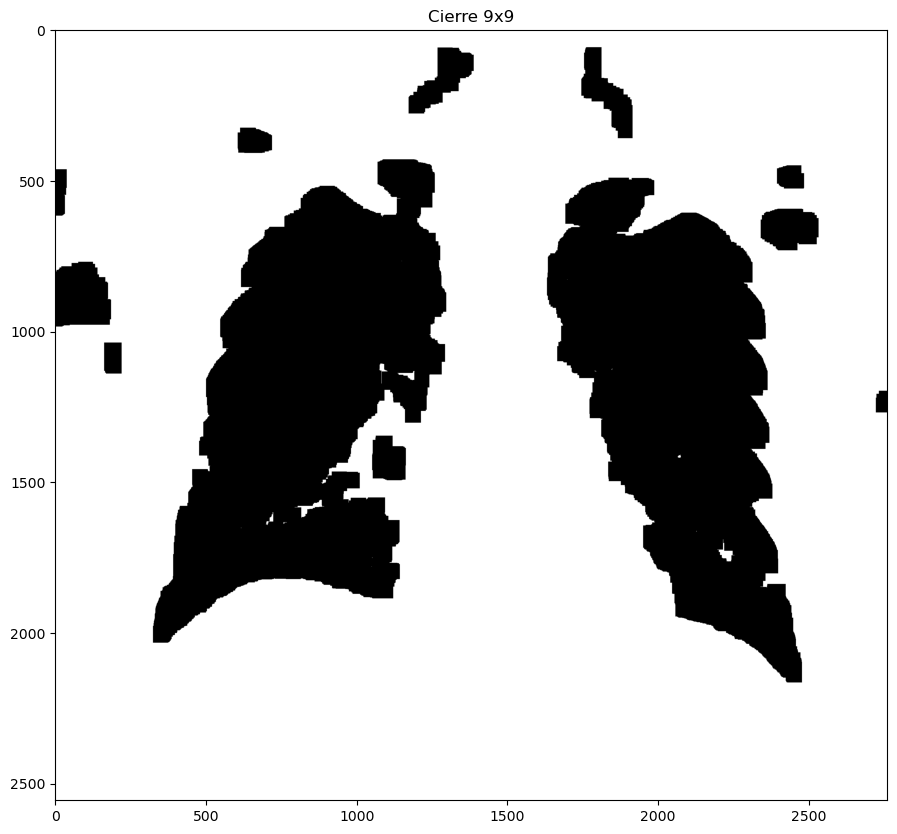

In [71]:
closing_pulmon = cv2.morphologyEx(thresh_pulmon, cv2.MORPH_CLOSE, kernel, iterations=6)
show_image(closing_pulmon,'Cierre 9x9')

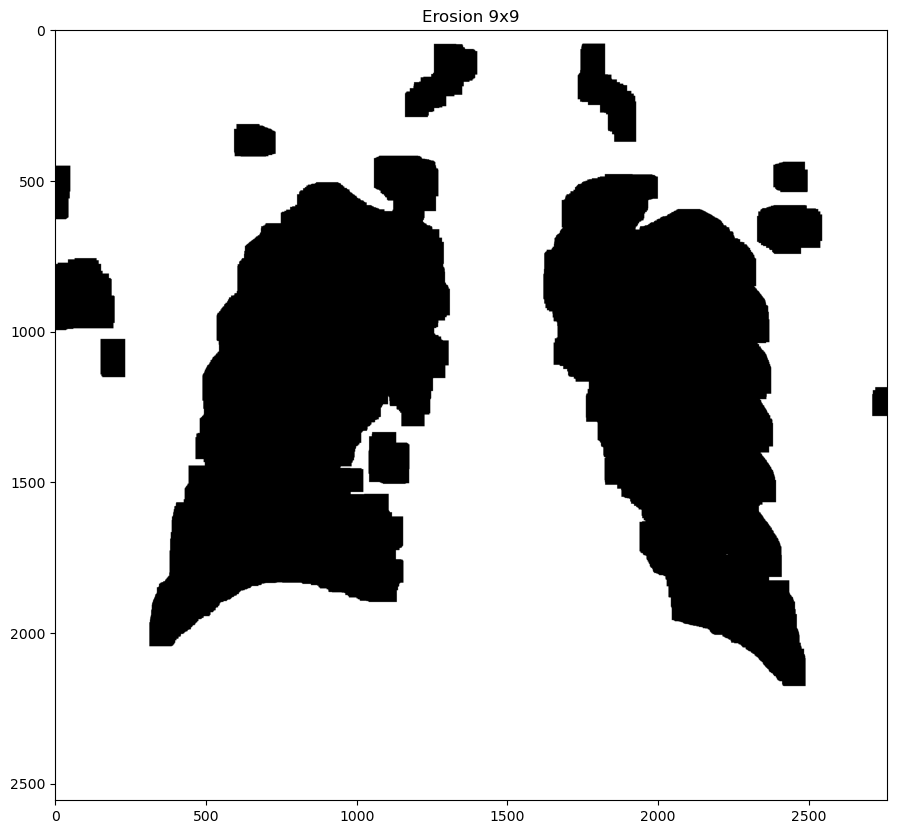

In [72]:
erosion_pulmon = cv2.erode(closing_pulmon,kernel,iterations=3)
show_image(erosion_pulmon,'Erosion 9x9')

### Determinar contornos
Se tendrán en cuenta solo las 2 áreas mas grandes que representan los 2 pulmones. Ademas se invierte los colores pasando el objeto de estudio a color blanco y el fondo negro

In [73]:
mask_pulmon = ~erosion_pulmon
contours, _ = cv2.findContours(mask_pulmon,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
print("Nºs de contornos:",len(contours))

Nºs de contornos: 12


In [74]:
list_areas = []
for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    list_areas.append({
        'i':i,
        'area':area,
    })

list_areas=sorted(list_areas, key=lambda i: i['area'], reverse=True)

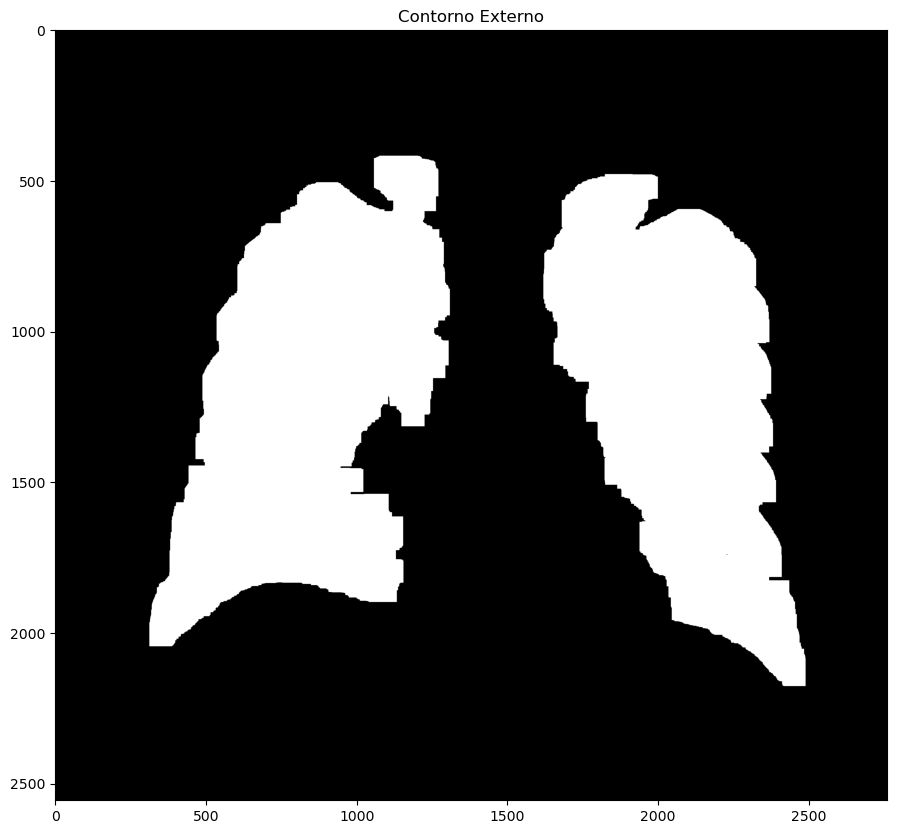

In [75]:
for i, area in enumerate(list_areas[2:]):
    cv2.drawContours(mask_pulmon, contours, area['i'], (0,0,0), cv2.FILLED)
show_image(mask_pulmon,'Contorno Externo')

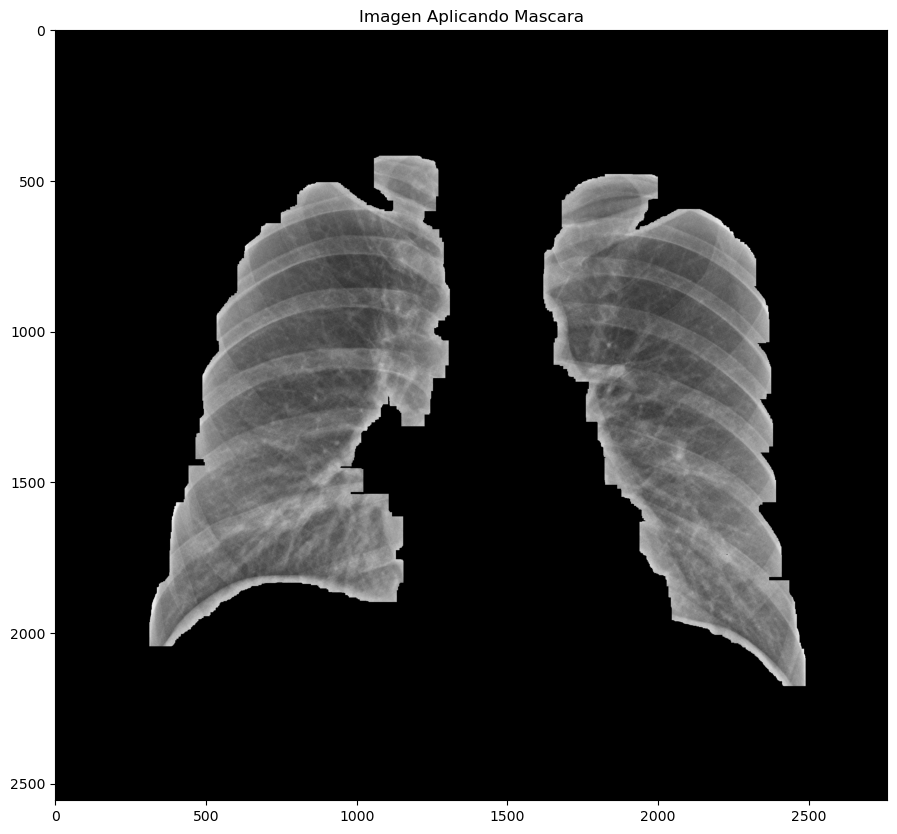

In [76]:
masked = cv2.bitwise_and(img, img, mask=mask_pulmon)
show_image(masked,'Imagen Aplicando Mascara')

### Comparación con máscara manual


C:\Users\Fabian\AppData\Local\Temp\ipykernel_10576\2087360564.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('./imagenes/dataset/MCUCXR_0350_1.png')
C:\Users\Fabian\AppData\Local\Temp\ipykernel_10576\2087360564.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_left = imageio.imread('./imagenes/dataset/MCUCXR_0350_1L.png')
C:\Users\Fabian\AppData\Local\Temp\ipykernel_10576\2087360564.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning 

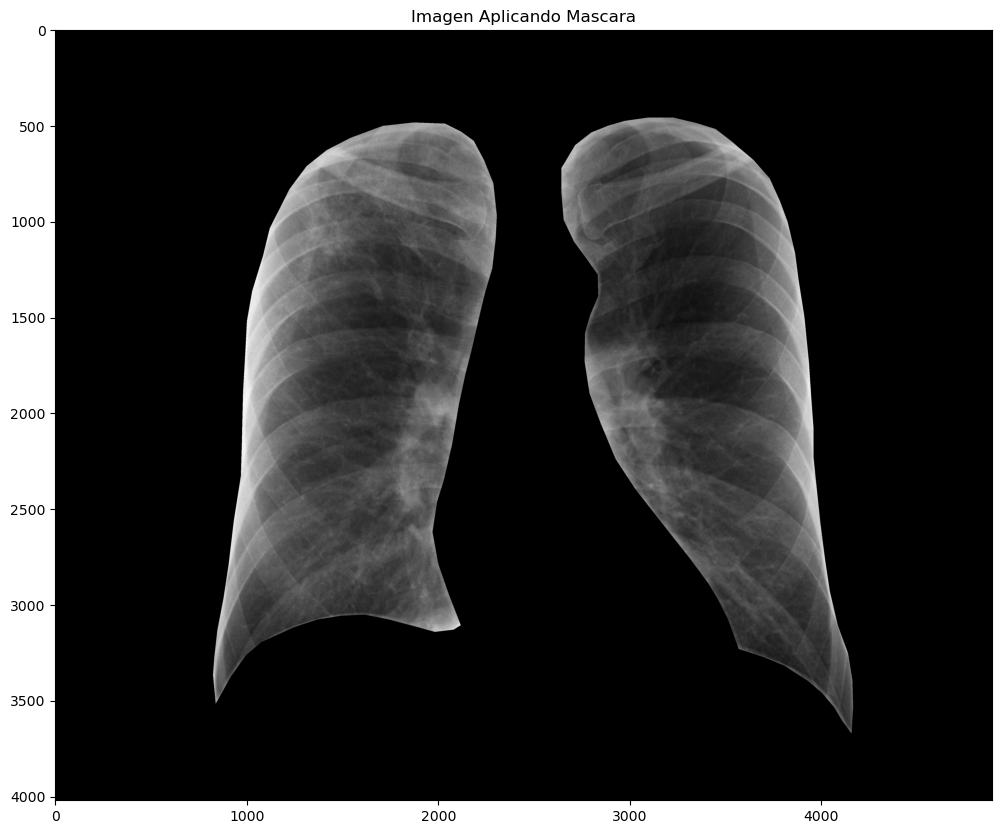

In [49]:
img = imageio.imread('./imagenes/dataset/MCUCXR_0350_1.png')
mask_left = imageio.imread('./imagenes/dataset/MCUCXR_0350_1L.png')
mask_right = imageio.imread('./imagenes/dataset/MCUCXR_0350_1R.png')
result = mask_left + mask_right
masked = cv2.bitwise_and(img, img, mask=result)
show_image(masked,'Imagen Aplicando Mascara')